# <center> Sweeping over multiple variables demonstration

### <center> This notebook demonstrates how to run a ND variable sweep using the NDAveragerProgram.

When running parameter sweep experiments, to cancel the effect of slow drifting of room temperature electronics, we usually prefer to run all the sweeps in the fast FPGA program, and put the repetition as the last iteration axis. 

In this notebook, we show how to run a 2D sweep over both "phase" and "gain" of a generator channel in one qick program. i.e. for each phase value in the "phi_list", the gain value will be swept over all the values in "g_list", then the whole 2D parameter sweep will be repeated for "reps" number of times, all in qick program.

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from qick.averager_program import QickSweep
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load bitstream with custom overlay
soc = QickSoc()
# Since we're running locally on the QICK, we don't need a separate QickConfig object.
# If running remotely, you could generate a QickConfig from the QickSoc:
#     soccfg = QickConfig(soc.get_cfg())
# or save the config to file, and load it later:
#     with open("qick_config.json", "w") as f:
#         f.write(soc.dump_cfg())
#     soccfg = QickConfig("qick_config.json")
soccfg = soc
# print(soccfg)

### Hardware Configuration

tProc channel 7   : DAC 229 CH3  <-> Readout channel 0 : ADC 224 CH0

### Example 1: 2D sweep over gain and phase

In [4]:
class NDSweepProgram(NDAveragerProgram):
    def initialize(self):
        cfg = self.cfg
        res_ch = cfg["res_ch"]

        self.declare_gen(ch=cfg["res_ch"], nqz=1, ro_ch=cfg["ro_chs"][0])

        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"], gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["phi_start"], gen_ch=res_ch)
        gain = cfg["g_start"]

        self.set_pulse_registers(ch=res_ch, style="const", freq=freq, phase=phase, gain=gain, length=cfg["length"])
        
        # ---------- sweep defination starts from here -----------------
        # get gain and phase registers of the generator channel (check 04_Reading_Math_Writing for more details about QickRegister object)
        self.res_r_gain = self.get_gen_reg(cfg["res_ch"], "gain")
        self.res_r_phase = self.get_gen_reg(cfg["res_ch"], "phase")

        # add pulse gain and phase sweep, first added will be first swept
        self.add_sweep(QickSweep(self, self.res_r_gain, cfg["g_start"], cfg["g_stop"], cfg["g_expts"]))
        self.add_sweep(QickSweep(self, self.res_r_phase, cfg["phi_start"], cfg["phi_stop"], cfg["phi_expts"]))


        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.measure(pulse_ch=self.cfg["res_ch"],
                     adcs=self.ro_chs,
                     pins=[0],
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

# unlike the RAveragerProgram, here we only have initialize() and body() part in the program, and the register update 
# parts (which will be run after each body) are programed in QickSweep objects. 

In [5]:
config = {"res_ch": 6,  # --Fixed
          "ro_chs": [0],  # --Fixed
          "reps": 100,  # --Fixed
          "relax_delay": 1.0,  # --us

          "length": 50,  # [Clock ticks]
          # Try varying length from 10-100 clock ticks

          "readout_length": 100,  # [Clock ticks]
          # Try varying readout_length from 50-1000 clock ticks

          "pulse_freq": 1500,  # [MHz]
          # In this program the signal is up and downconverted digitally so you won't see any frequency
          # components in the I/Q traces below. But since the signal gain depends on frequency,
          # if you lower pulse_freq you will see an increased gain.

          "adc_trig_offset": 150,  # [Clock ticks]
          # Try varying adc_trig_offset from 100 to 220 clock ticks

          "soft_avgs": 1,

          "rounds":1

          }

expt_cfg = {
    "g_start": 100,  # [DAC units]
    "g_stop": 10100,  # [DAC units]
    "g_expts": 101,

    "phi_start": 0,  # --degrees
    "phi_stop": 360,  # --degrees
    "phi_expts": 51,
}

config.update(**expt_cfg)

prog = NDSweepProgram(soccfg, config)
print(prog)
expt_pts, avg_di, avg_dq = prog.acquire(soc, progress=True) 
# expt_pts: list of sweep value lists
# avg_di: averaged i data, shape: (ro_chs, saved_experiments, sweep_axis_n, ..., sweep_axis_0)
# avg_dq: averaged q data, shape: (ro_chs, saved_experiments, sweep_axis_n, ..., sweep_axis_0)

avg_abs, avg_angle = np.abs(avg_di[0] + 1j * avg_dq[0]), np.angle(avg_di[0] + 1j * avg_dq[0])




// Program

                 regwi 3, $22, 936228570;       //freq = 936228570
                 regwi 3, $23, 0;               //phase = 0
                 regwi 3, $25, 100;             //gain = 100
                 regwi 3, $26, 589874;          //stdysel | mode | outsel = 0b01001 | length = 50 
                 synci 200;
                 regwi 0, $13, 0;
                 regwi 0, $14, 99;
LOOP_rep:        regwi 3, $23, 0;               //'gen6_phase' <= 0 (0 deg)
                 regwi 0, $16, 50;
LOOP_gen6_phase: regwi 3, $25, 100;             //'gen6_gain' <= 100 
                 regwi 0, $15, 100;
LOOP_gen6_gain:  regwi 0, $31, 16385;           //out = 0b0100000000000001
                 seti 0, 0, $31, 150;           //ch =0 out = $31 @t = 0
                 seti 0, 0, $0, 160;            //ch =0 out = 0 @t = 0
                 regwi 3, $27, 0;               //t = 0
                 set 7, 3, $22, $23, $0, $25, $26, $27;//ch = 6, pulse @t = $27
                 waiti 0, 290;


  0%|          | 0/515100 [00:00<?, ?it/s]

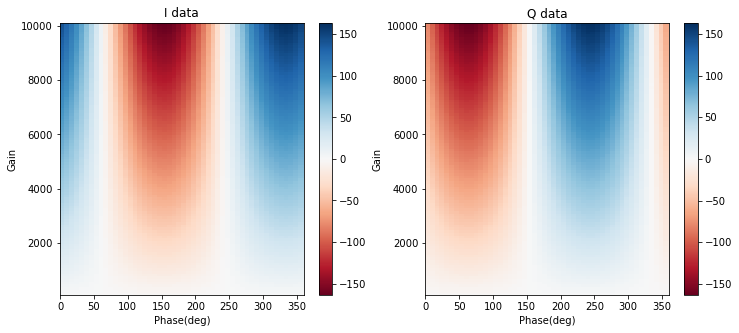

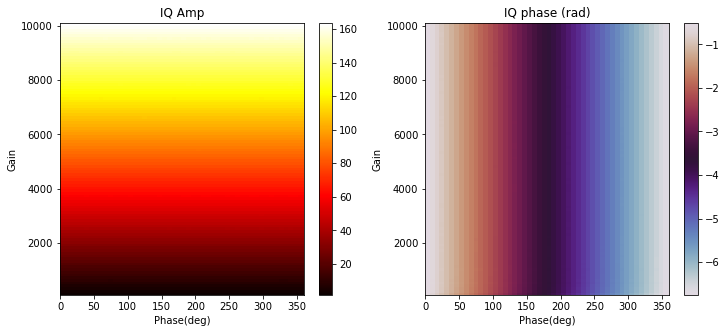

In [6]:
# plot data
fig, axes = plt.subplots(1, 2, figsize=(12,5))
for i, d in enumerate([avg_di, avg_dq]):
    pcm = axes[i].pcolormesh(prog.get_expt_pts()[1], prog.get_expt_pts()[0], d[0][0].T, shading="Auto", cmap="RdBu")
    axes[i].set_xlabel("Phase(deg)")
    axes[i].set_ylabel("Gain")
    axes[i].set_title("I data" if i ==0  else "Q data")
    plt.colorbar(pcm, ax=axes[i])

fig, axes = plt.subplots(1, 2, figsize=(12,5))
for i, d in enumerate([avg_abs, avg_angle]):
    if i==0:
        pcm = axes[i].pcolormesh(prog.get_expt_pts()[1], prog.get_expt_pts()[0], d[0].T, shading="Auto", cmap="hot")
    else:
        pcm = axes[i].pcolormesh(prog.get_expt_pts()[1], prog.get_expt_pts()[0], np.unwrap(d[0].T), shading="Auto",cmap="twilight")
    axes[i].set_xlabel("Phase(deg)")
    axes[i].set_ylabel("Gain")
    axes[i].set_title("IQ Amp" if i ==0  else "IQ phase (rad)")
    plt.colorbar(pcm, ax=axes[i])

### Example 2: when the parameter we sweep over needs to jump between a constant value and a sweep value

A practical example can be transmon ef pulse spec, in which the first qubit pulse of each experiment will be a pi pulse at the ge frequency that prepares the qubit to e state, and the second pulse's frequency needs to sweep around the ef frequency.

Here, for simplicity, we make the gain jump between a constant value and a sweep value to demonstrate the idea.

In [7]:
class NDSweepProgram_2(NDAveragerProgram):
    def initialize(self):
        cfg = self.cfg
        res_ch = cfg["res_ch"]

        self.declare_gen(ch=cfg["res_ch"], nqz=1, ro_ch=cfg["ro_chs"][0])

        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"], gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["phi_start"], gen_ch=res_ch)
        gain = cfg["g0"]

        self.set_pulse_registers(ch=res_ch, style="const", freq=freq, phase=phase, gain=gain, length=cfg["length"])
        
        # ---------- sweep defination starts from here -----------------
        # get gain and phase registers of the generator channel (check 04_Reading_Math_Writing for more details about QickRegister object)
        self.res_r_gain = self.get_gen_reg(cfg["res_ch"], "gain")
        # declare a new register in the res_ch register page that keeps the sweep value
        self.res_r_gain_update = self.new_gen_reg(cfg["res_ch"], init_val=cfg["g_start"], name="gain_update") 
        self.res_r_phase = self.get_gen_reg(cfg["res_ch"], "phase")

        # add pulse gain and phase sweep, first added will be first swept
        self.add_sweep(QickSweep(self, self.res_r_gain_update, cfg["g_start"], cfg["g_stop"], cfg["g_expts"])) # now sweep over "res_r_gain_update"
        self.add_sweep(QickSweep(self, self.res_r_phase, cfg["phi_start"], cfg["phi_stop"], cfg["phi_expts"]))


        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        # first pulse has fixed gain g0
        self.res_r_gain.set_to(self.cfg["g0"]) # same as: self.safe_regwi(self.res_r_gain.page, self.res_r_gain.addr, self.cfg["g0"])
        self.measure(pulse_ch=self.cfg["res_ch"],
                     adcs=self.ro_chs,
                     pins=[0],
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

        # second pulse sweeps gain value
        self.res_r_gain.set_to(self.res_r_gain_update) # same as: self.mathi(self.res_r_gain.page, self.res_r_gain.addr, self.res_r_gain_update.addr, "+", 0)
        self.measure(pulse_ch=self.cfg["res_ch"],
                     adcs=self.ro_chs,
                     pins=[0],
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

In [10]:
config2 = {"res_ch": 6,  # --Fixed
          "ro_chs": [0],  # --Fixed
          "reps": 100,  # --Fixed
          "relax_delay": 1.0,  # --us

          "length": 50,  # [Clock ticks]
          # Try varying length from 10-100 clock ticks

          "readout_length": 100,  # [Clock ticks]
          # Try varying readout_length from 50-1000 clock ticks

          "pulse_freq": 1500,  # [MHz]
          # In this program the signal is up and downconverted digitally so you won't see any frequency
          # components in the I/Q traces below. But since the signal gain depends on frequency,
          # if you lower pulse_freq you will see an increased gain.

          "adc_trig_offset": 150,  # [Clock ticks]
          # Try varying adc_trig_offset from 100 to 220 clock ticks

          "soft_avgs": 1,

          "rounds":1

          }

expt_cfg2 = {
    "g0": 5000, # [DAC units]

    "g_start": 100,  # [DAC units]
    "g_stop": 10100,  # [DAC units]
    "g_expts": 101,

    "phi_start": 0,  # --degrees
    "phi_stop": 360,  # --degrees
    "phi_expts": 51,
}

config2.update(**expt_cfg2)

prog = NDSweepProgram_2(soccfg, config2)
# print(prog)
expt_pts, avg_di, avg_dq = prog.acquire(soc, progress=True) 

avg_abs, avg_angle = np.abs(avg_di[0] + 1j * avg_dq[0]), np.angle(avg_di[0] + 1j * avg_dq[0])

  0%|          | 0/1030200 [00:00<?, ?it/s]

In [10]:
print(avg_di[0].shape)

(1, 2, 51, 101)


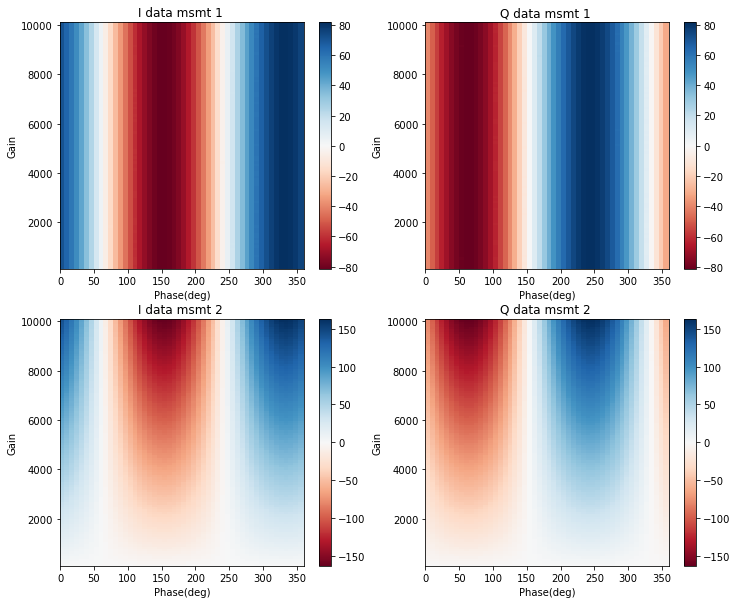

In [11]:
# plot data
fig, axes = plt.subplots(2, 2, figsize=(12,10))
for j in range(2):
    for i, d in enumerate([avg_di, avg_dq]):
        pcm = axes[j,i].pcolormesh(prog.get_expt_pts()[1], prog.get_expt_pts()[0], d[0][j].T, shading="Auto", cmap="RdBu")
        axes[j, i].set_xlabel("Phase(deg)")
        axes[j, i].set_ylabel("Gain")
        axes[j, i].set_title(f"I data msmt {j+1} " if i ==0  else f"Q data msmt {j+1} ")
        plt.colorbar(pcm, ax=axes[j, i])
